In [1]:
"""
make_swan_input_Lee

Code to make SWAN input requesting SPEC2D output for drifters during Hurricane Lee

This notebook is based on the really nice example provided by Jacob Davis (davisjr@uw.edu)

Example code for loading and working with Spotter data from the NHCI
aggregated drifter dataset in Python .pickle format. Since all datasets
have the same variable names and structure, this example framework can
also be used for DWSD and microSWIFT drifters.

"""

import os
import pickle
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import pandas as pd

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Lee/'
DRIFTER_DATA_FILENAME = 'hurricane_lee_drifter_data_v1.pickle'

In [2]:
with open(os.path.join(DATA_DIRECTORY, DRIFTER_DATA_FILENAME), 'rb') as handle:
    drifters = pickle.load(handle)

# `drifters` is a python dictionary keyed by drifter type (spotter,
# dwsd, or microswift)
# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter = drifters['spotter']
spotter_ids = list(spotter.keys())
for id in spotter_ids:
    print(id)

dwsd = drifters['dwsd']
dwsd_ids = list(dwsd.keys())
for id in dwsd_ids:
    print(id)
    
mswift = drifters['microswift']
mswift_ids = list(mswift.keys())
for id in mswift_ids:
    print(id)

SPOT-31232C
SPOT-1207
SPOT-1184
SPOT-1255
SPOT-010349
SPOT-010408
SPOT-1240
SPOT-1188
300534061901680
300534061901630
300534061901660
041
050
059
065


In [3]:
# Make nicknames for these drifters to conform with the max. 8 char limit in SWAN filesname
# after adding three characters for a counter (to differentiate the POINTS).
# This is a manual step
snames = ['S232','S207','S184','S255','S349','S408','S240','S188']
dnames = ['D680','D630','D660']
mnames = ['M041','M050','M059','M065']

# Check to see if they are correct
for i, id in enumerate( spotter_ids) :
    print(id,snames[i])
for i, id in enumerate( dwsd_ids) :
    print(id,dnames[i])
for i, id in enumerate( mswift_ids) :
    print(id,mnames[i])

SPOT-31232C S232
SPOT-1207 S207
SPOT-1184 S184
SPOT-1255 S255
SPOT-010349 S349
SPOT-010408 S408
SPOT-1240 S240
SPOT-1188 S188
300534061901680 D680
300534061901630 D630
300534061901660 D660
041 M041
050 M050
059 M059
065 M065


In [4]:
# The data for a single id (e.g. the first) can be accessed as:
spotter_id = spotter_ids[0] # = 'SPOT-30068D'
spotter[spotter_id].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 221 entries, 2023-09-14 21:25:00+00:00 to 2023-09-17 23:45:00+00:00
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 221 non-null    float64
 1   longitude                221 non-null    float64
 2   significant_height       74 non-null     float64
 3   peak_period              74 non-null     float64
 4   peak_direction           74 non-null     float64
 5   peak_directional_spread  74 non-null     float64
 6   mean_period              74 non-null     float64
 7   mean_direction           74 non-null     float64
 8   mean_directional_spread  74 non-null     float64
 9   frequency                74 non-null     object 
 10  energy_density           74 non-null     object 
 11  a1                       74 non-null     object 
 12  b1                       74 non-null     object 
 13  a2                       74 non

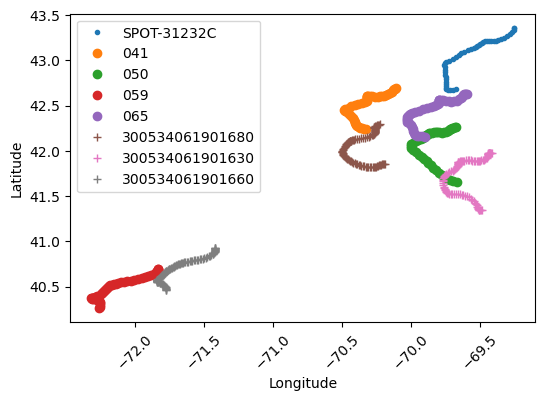

In [5]:
# example: plot lat, lon for positions with valid wave data
import numpy as np
fig, ax = plt.subplots(figsize=(6,4))
for spotter_id in spotter.keys():
    if spotter[spotter_id]['latitude'].max() > 40.:
        only_waves = spotter[spotter_id]['energy_density'].notnull()
        ax.plot(
            spotter[spotter_id][only_waves]['longitude'].loc['2023-09-15':'2023-09-16'],
            spotter[spotter_id][only_waves]['latitude'].loc['2023-09-15':'2023-09-16'],'.',
            label = spotter_id,
        )
for mswift_id in mswift.keys():
    ax.plot(
        mswift[mswift_id]['longitude'].loc['2023-09-15':'2023-09-16'],
        mswift[mswift_id]['latitude'].loc['2023-09-15':'2023-09-16'],'o',
        label = mswift_id,
    )
for dwsd_id in dwsd.keys():
    ax.plot(
        dwsd[dwsd_id]['longitude'].loc['2023-09-15':'2023-09-16'],
        dwsd[dwsd_id]['latitude'].loc['2023-09-15':'2023-09-16'],'+',
        label = dwsd_id,
    )
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.legend()
ax.tick_params(axis='x', rotation=45)

In [6]:
# Open a file text to be cut+pasted into SWAN input file for spotters
f = open(DATA_DIRECTORY+'lee_spotter_spec2d.txt', 'w')
for nid, spotter_id in enumerate( spotter.keys() ):
    # Eliminate southern Spotters
    if spotter[spotter_id]['latitude'].max() > 40.:

        # Some rows have times with other data but no wave info (Spotters only)
        only_waves = spotter[spotter_id]['energy_density'].notnull()

        ipt = 0 # index must stay below 100 or file names will be too long
        for index, row in spotter[spotter_id][only_waves].loc['2023-09-15':'2023-09-16'].iterrows():
            #print(index, row['latitude'])
            spectime = index.strftime('%Y%m%d.%H%m')
            pname = "{}{:03d}".format(snames[nid], ipt)
            pline = ("POINTS '{}' {:.4f} {:.4f}".format(pname, row['longitude'], row['latitude'] )) 
            sline = "SPECOUT '{}' SPEC2D ABS '{}.spc2d' OUTPUT {} 1000 HR".format( pname, pname, spectime )
            # print(pline)
            # print(sline)
            f.write(pline+'\n')
            f.write(sline+'\n')
            ipt +=1
            if(ipt >= 100):
                print("Warning: SWAN output filename prefix exceeds 8 chars.")

f.close()

In [7]:
# Open a file text to be cut+pasted into SWAN input file for microswifts
f1 = open(DATA_DIRECTORY+'lee_mswift_spec2d.txt', 'w')
for nid, mswift_id in enumerate (mswift.keys() ):
    ipt = 0 # index must stay below 100 or file names will be too long
    for index, row in mswift[mswift_id].iterrows():
        #print(index, row['latitude'])
        pname = "{}{:03d}".format(mnames[nid], ipt)
        starttime = index.strftime('%Y%m%d.%H%m')
        pline = ("POINTS '{}' {:.4f} {:.4f}".format(pname, row['longitude'], row['latitude'] )) 
        sline = "SPECOUT '{}' SPEC2D ABS '{}.spc2d' OUTPUT {} 1000 HR".format( pname, pname, starttime )
        # print(pline)
        # print(sline)
        f1.write(pline+'\n')
        f1.write(sline+'\n')
        ipt +=1
        if(ipt >= 100):
            print("Warning: SWAN output filename prefix exceeds 8 chars.")
    
f1.close()

In [8]:
# Open a file text to be cut+pasted into SWAN input file for dwsd drifters
# These have ids that are too long, so make a shorter name for SWAN
f2 = open(DATA_DIRECTORY+'lee_dwsd_spec2d.txt', 'w')
for nid, dwsd_id in enumerate( dwsd.keys() ):
    ipt = 0  # index must stay below 100 or file names will be too long
    for index, row in dwsd[dwsd_id].iterrows():
        pname = "{}{:03d}".format(dnames[nid], ipt)
        starttime = index.strftime('%Y%m%d.%H%m')
        pline = ("POINTS '{}' {:.4f} {:.4f}".format(pname, row['longitude'], row['latitude'] )) 
        sline = "SPECOUT '{}' SPEC2D ABS '{}.spc2d' OUTPUT {} 1000 HR".format( pname, pname, starttime )
        # print(pline)
        # print(sline)
        f2.write(pline+'\n')
        f2.write(sline+'\n')
        ipt +=1
        if(ipt >= 1000):
            print("Warning: SWAN output filename prefix exceeds 8 chars.")
    
f2.close()